<a href="https://colab.research.google.com/github/maicon-reis/python_para_financas/blob/main/RSI_Trade_Fun%C3%A7%C3%A3o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q yfinance

     |████████████████████████████████| 6.3 MB 6.5 MB/s 


# **1. Criando Função que calcula RSI**

In [ ]:
# bibliotecas
from datetime import date
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib
import datetime as dt
pd.options.mode.chained_assignment = None

def RSIcalc(asset):
    '''
    Função que calcula média movel de 200 e RSI.
    '''
    # coletando dados
    df = yf.download( asset, start=dt.datetime( 2015, 1, 1 ), end=dt.datetime.now() )

    # calcula média móvel de 200 períodos
    df.loc[ :, 'MA200' ] = df[ 'Adj Close' ].rolling( window=200 ).mean()

    # retornos relativos (retornos diários)
    df.loc[ :, 'price change'] = df[ 'Adj Close' ].pct_change()

    # coletando períodos positivos e negativos
    df.loc[ :,  'Upmove' ] = df[ 'price change' ].apply( lambda x: x if x > 0 else 0 )
    df.loc[ :, 'Downmove' ] = df[ 'price change' ].apply( lambda x: abs( x ) if x < 0 else 0 )

    # calculando média de 19 períodos
    df.loc[ :,  'avg Up' ] = df[ 'Upmove' ].ewm( span=14 ).mean()
    df.loc[ :,  'avg Down' ] = df[ 'Downmove' ].ewm( span=14 ).mean()
    df.dropna(inplace=True)

    # Calculando a força relativa obtida entre períodos de alta e baixa
    df.loc[ :, 'RS' ] = df[ 'avg Up' ] / df[ 'avg Down' ]

    # Calculando o indicador RSI
    df.loc[ :, 'RSI' ] = df[ 'RS' ].apply( lambda x: 100 - ( 100 / ( x+1 ) ) )

    # Regra de Trade Caso o RSI seja maior que zero e o nível de preço/pontos
    # esteja acima da média de 200 indica compra
    df.loc[ ( df[ 'Adj Close' ] > df[ 'MA200' ] ) & ( df[ 'RSI' ] < 30 ), 'Buy' ] = 'Yes'
    df.loc[ ( df[ 'Adj Close' ] < df[ 'MA200' ] ) | ( df[ 'RSI' ] > 30 ), 'Buy' ] = 'No'
    return df

def getSignals(df):
    '''
    Função para coletar sinal de compra e venda.
    '''
    buying_dates = []
    selling_dates = []

    for i in range(len(df)):
        if 'Yes' in df['Buy'].iloc[i]:
            buying_dates.append(df.iloc[i+1].name)
            for j in range(1, 11):
                if df['RSI'].iloc[i+j] > 40:
                    selling_dates.append(df.iloc[i+j+1].name)
                    break
                elif j == 10:
                    selling_dates.append(df.iloc[i+j+1].name)
    return buying_dates, selling_dates

# **2. Coleta Ações que compõem o Ibov**

In [ ]:
# Webscrapping das ações que compôem o Ibov
tickers = pd.read_html('https://pt.wikipedia.org/wiki/Lista_de_companhias_citadas_no_Ibovespa')[0]
ativos = tickers.Código.to_list()
lista_ativos = []
for ativo in ativos:
    lista_ativos.append('{}.SA'.format(ativo))

# **3. Cria matriz com resultados**

In [ ]:
# cria uma matriz com os sinais e resultados de todos os ativos
matrixsignals = []
matrixprofits = []

for i in range(len(lista_ativos)):
    try:
        frame = RSIcalc(lista_ativos[i])
        buy, sell = getSignals(frame)
        profits = (frame.loc[sell].Open.values - frame.loc[buy].Open.values) / frame.loc[buy].Open.values
        matrixsignals.append(buy)
        matrixprofits.append(profits)
    except Exception:
        continue

# Unindo todos os resultados em uma única lista
allprofit = []
for i in matrixprofits:
    for e in i:
        allprofit.append(e)

# Coletando dentre os resultados apenas os positivos
wins = [i for i in allprofit if i > 0]

print('Proporção de trades vencedores: {}%'.format(round(len(wins)/len(allprofit) * 100, 2)))

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

# **4. Cria Gráfico de Dispersão com Resultados**

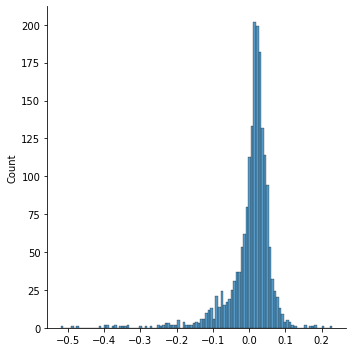

In [ ]:
import seaborn as sns

sns.displot(allprofit)
plt.show()